# example of de novo alignment of multiple slices

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import skimage
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import scanpy as sc
import sys
import anndata as ad
import pickle

sys.path.append('../code/')
from libs.utils import simple_efm_kwargs_generator
from libs.models import STaCkerSemiSupervised
from libs.alignment import stacker_register
from libs.utils.image.transcriptome import createCompositeImg
from libs.utils.auxiliary import *

seed = 0
rng = np.random.default_rng(seed)

num_gpus = len(tf.config.list_physical_devices("GPU"))
gpus_color = '\033[0;32m' if num_gpus > 0 else '\033[0;31m'
gpus_string = f"{gpus_color}{num_gpus}\033[0m"
print(f'Recognized GPUs: {gpus_string}')

2023-10-31 18:56:31.331915: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Recognized GPUs: 4


2023-10-31 18:56:35.777945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 18:56:35.781086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 18:56:35.784192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 18:56:35.787297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 18:56:35.790564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from S

In [2]:
# load unaligned slices

PIK='testing/example2_input.obj' 
with open(PIK, "rb") as f:
    [miniext]=pickle.load(f)



In [3]:
# preparation data: scale, crop/pad the slices to similar size and orientation 

rescaled=scaleAdata(miniext, ratio=0.07, finalhires=512, coarse=0)


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.

 bad det -1 v 1 u -1
 bad det -1 v 1 u -1 new 1


rangeX=408.50583583678474
[405.6095428466797, 410.5528351870922, 406.4588364864772, 412.7515637029367]
[408.49869524297674, 396.5238706113287, 406.1816732928202, 408.51612223722395]
rangeY=358.12972307490895
[355.03031635284424, 370.8323424914828, 358.37470053646155, 357.8847456133564]
[357.55830303762747, 358.1639774210407, 358.1304066540265, 354.2136862093375]
[54.27191967830642, 50.302520645095306]
[114.40731792150763, 120.32524382747683, 115.55238389494087, 114.39870554814173]
[139.58192180635623, 139.28259916619746, 139.2991897483486, 141.23482238590768]


In [4]:
# For each slice, construct composite image using the tissue image and the contour map based on transcriptomic clusters

clust_file='testing/example2_spots.csv'
for each in range(len(rescaled)):
    rescaled[each]=createCompositeImg(rescaled[each],clust_file=clust_file,res="hires",maskval=0,med_filter_size=4,trimMax=2)



In [5]:
# load model (assumed already trained)

model_sm = STaCkerSemiSupervised(img_shape=(256,256,3),
                                    lbl_shape=(256,256,3),
                                    auxiliary_outputs=['def_output', 'inv_def_output'],
                                    efm_kwargs=simple_efm_kwargs_generator(dict_inputs=True,
                                                                           dict_outputs=True,
                                                                           output_names_list=['moved_img',
                                                                                              'def_output',
                                                                                              'inv_def_output',
                                                                                              'moved_lbl']))
model_sm.load_weights('data/stacker-params-sample/checkpoints/variables/variables')
model_sm = model_sm.references.base_model

model_sm.get_input_signature()

2023-10-31 18:59:35.878103: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 18:59:36.617381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 18:59:36.619275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 18:59:36.621092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

{'sm_semi_base_moving_img': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='sm_semi_base_moving_img'),
 'sm_semi_base_fixed_img': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='sm_semi_base_fixed_img')}

In [6]:
 rs = stacker_register(slices=rescaled,
                     alignment_mode='templateless',
                     spatial_strategy='points',
                     spatial_target='hires',
                     max_reg_dim=512,
                     mode='dense',
                     model=model_sm,
                     dense_moving_img_name='sm_semi_base_moving_img',
                     dense_fixed_img_name='sm_semi_base_fixed_img',
                     dense_deff_name='def_output',
                     dense_inv_deff_name='inv_def_output',
                     search_factor=5)


2023-10-31 18:59:47.570452: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


----- unaligned --------


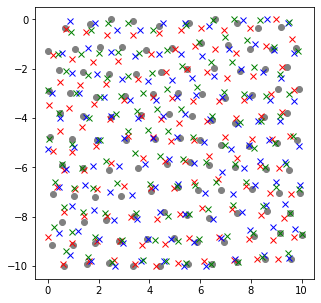

In [7]:
 print("----- unaligned --------")
 coord1=scale_spatial_coords2(rescaled[0].obsm['spatial'])
 coord2=scale_spatial_coords2(rescaled[1].obsm['spatial'],ref_min=rescaled[0].obsm['spatial'].min(0),
                          ref_max=(rescaled[0].obsm['spatial']-rescaled[0].obsm['spatial'].min(0)).max(0))
 coord3=scale_spatial_coords2(rescaled[2].obsm['spatial'],ref_min=rescaled[0].obsm['spatial'].min(0),
                          ref_max=(rescaled[0].obsm['spatial']-rescaled[0].obsm['spatial'].min(0)).max(0))
 coord4=scale_spatial_coords2(rescaled[3].obsm['spatial'],ref_min=rescaled[0].obsm['spatial'].min(0),
                          ref_max=(rescaled[0].obsm['spatial']-rescaled[0].obsm['spatial'].min(0)).max(0))
 plt.figure(figsize=(5,5))
 plt.plot(coord1[:,0], -coord1[:,1], 'o', color='grey');
 plt.plot(coord2[:,0], -coord2[:,1], 'x', color='red');
 plt.plot(coord3[:,0], -coord3[:,1], 'x', color='blue');
 plt.plot(coord4[:,0], -coord4[:,1], 'x', color='green');


----- templateless --------


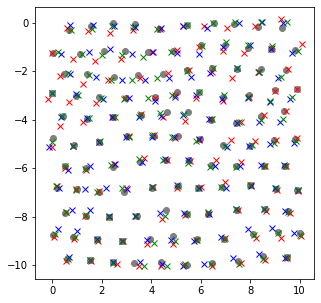

In [8]:
 templateless_spatial=[each.obsm['spatial'] for each in rs]

 print("----- templateless --------")
 plt.figure(figsize=(5,5))
 coord1=scale_spatial_coords2(templateless_spatial[0])
 coord2=scale_spatial_coords2(templateless_spatial[1],ref_min=templateless_spatial[0].min(0),
                          ref_max=(templateless_spatial[0]-templateless_spatial[0].min(0)).max(0))
 coord3=scale_spatial_coords2(templateless_spatial[2],ref_min=templateless_spatial[0].min(0),
                          ref_max=(templateless_spatial[0]-templateless_spatial[0].min(0)).max(0))
 coord4=scale_spatial_coords2(templateless_spatial[3],ref_min=templateless_spatial[0].min(0),
                          ref_max=(templateless_spatial[0]-templateless_spatial[0].min(0)).max(0))
 plt.plot(coord1[:,0], -coord1[:,1], 'o', color='grey');
 plt.plot(coord2[:,0], -coord2[:,1], 'x', color='red');
 plt.plot(coord3[:,0], -coord3[:,1], 'x', color='blue');
 plt.plot(coord4[:,0], -coord4[:,1], 'x', color='green');


